In [3]:
import numpy as np
import pandas as pd
import seaborn
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson, jarque_bera
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pd.get_data_yahoo = pdr.get_data_yahoo
from pykalman import KalmanFilter
from numpy import log, polyfit, sqrt, std, subtract
import ffn

## Step 1: Identifying Multiple Cointegrated Pairs

In [4]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = [
    'AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY', 
    'CSCO', 'NVDA', 'INTC', 'TXN', 'CRM', 'AMZN', 'GOOGL', 'META', 
    'XLK', 'QQQ', 
]


df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  21 of 21 completed


Ticker,AAPL,ADBE,AMD,AMZN,CRM,CSCO,EBAY,GOOGL,HPQ,IBM,...,JNPR,META,MSFT,NVDA,ORCL,QCOM,QQQ,SPY,TXN,XLK
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-24,36.707500,205.160004,16.650000,67.197998,121.330002,40.279999,26.139999,49.233501,19.379999,102.839386,...,25.559999,124.059998,94.129997,3.17700,42.689999,53.650002,143.500000,234.339996,87.800003,57.619999
2018-12-26,39.292500,222.949997,17.900000,73.544998,130.839996,42.470001,27.850000,52.392502,20.330000,106.491394,...,26.600000,134.179993,100.559998,3.32750,44.590000,55.959999,152.460007,246.179993,92.980003,61.099998
2018-12-27,39.037498,225.139999,17.490000,73.082001,135.199997,42.910000,28.030001,52.645000,20.379999,108.776291,...,26.799999,134.520004,101.180000,3.27925,44.970001,56.090000,153.050003,248.070007,93.809998,61.540001
2018-12-28,39.057499,223.130005,17.820000,73.901001,134.679993,42.770000,28.240000,52.334000,20.340000,108.059273,...,26.750000,133.199997,100.389999,3.34125,44.820000,56.810001,152.970001,247.750000,93.809998,61.400002
2018-12-31,39.435001,226.240005,18.459999,75.098503,136.970001,43.330002,28.070000,52.248001,20.459999,108.671127,...,26.910000,131.089996,101.570000,3.33750,45.150002,56.910000,154.259995,249.919998,94.500000,61.980000


In [5]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ADBE', 'CSCO'), ('ADBE', 'MSFT'), ('AMD', 'MSFT'), ('AMZN', 'CSCO'), ('CRM', 'MSFT'), ('CSCO', 'MSFT'), ('HPQ', 'ORCL'), ('ORCL', 'QQQ'), ('ORCL', 'SPY'), ('ORCL', 'TXN'), ('ORCL', 'XLK'), ('QQQ', 'SPY'), ('SPY', 'XLK')]


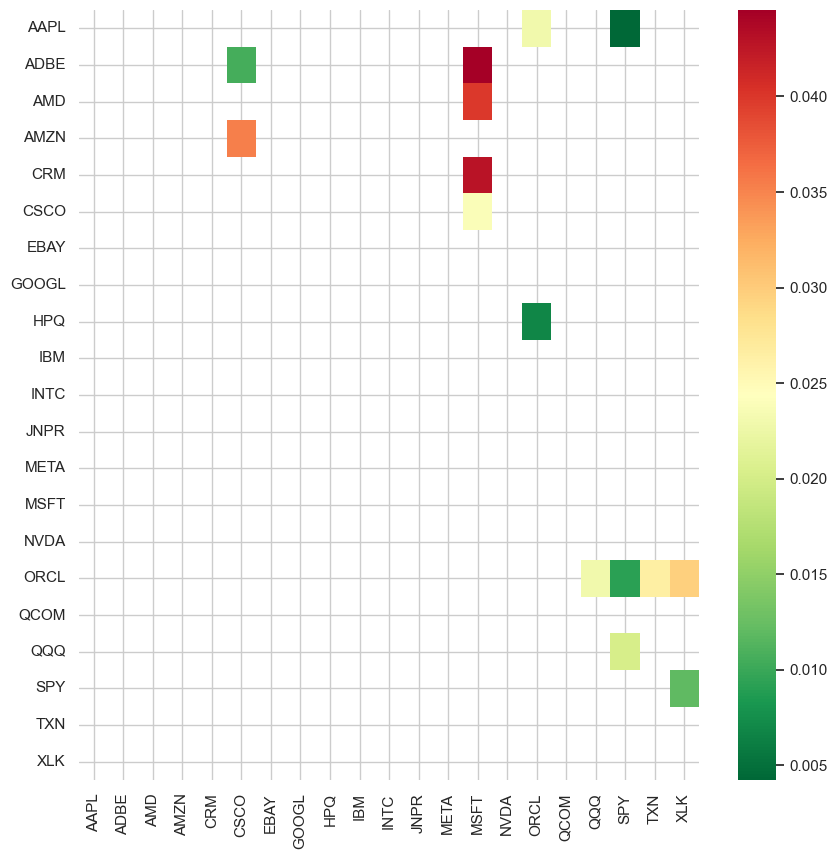

In [6]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

## Step 2: Kalman Filtering

In [7]:
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

In [8]:
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [9]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

In [24]:
train_size = int(0.7 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [44]:
def backtest(x, y):
    df1 = pd.DataFrame({'y':y, 'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    df1['hr'] = -state_means[:, 0]
  
    df1['spread'] = df1['y'] + (df1['x'] * df1['hr'])

    # Now you can calculate rolling mean and standard deviation of the spread
    halflife = half_life(df1['spread'])
    meanSpread = df1['spread'].rolling(window=halflife).mean()
    stdSpread = df1['spread'].rolling(window=halflife).std()

    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    entryZscore = 1.5
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < -entryZscore) & (df1.zScore.shift(1) > -entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1 

    try:
        sharpe = ((df1['port rets'].mean()/df1['port rets'].std()))*sqrt(252)
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe

Pair: ('AAPL', 'ORCL')
Sharpe Ratio: 0.7630841393095731
Final Cumulative Returns: 1.4745061361738385


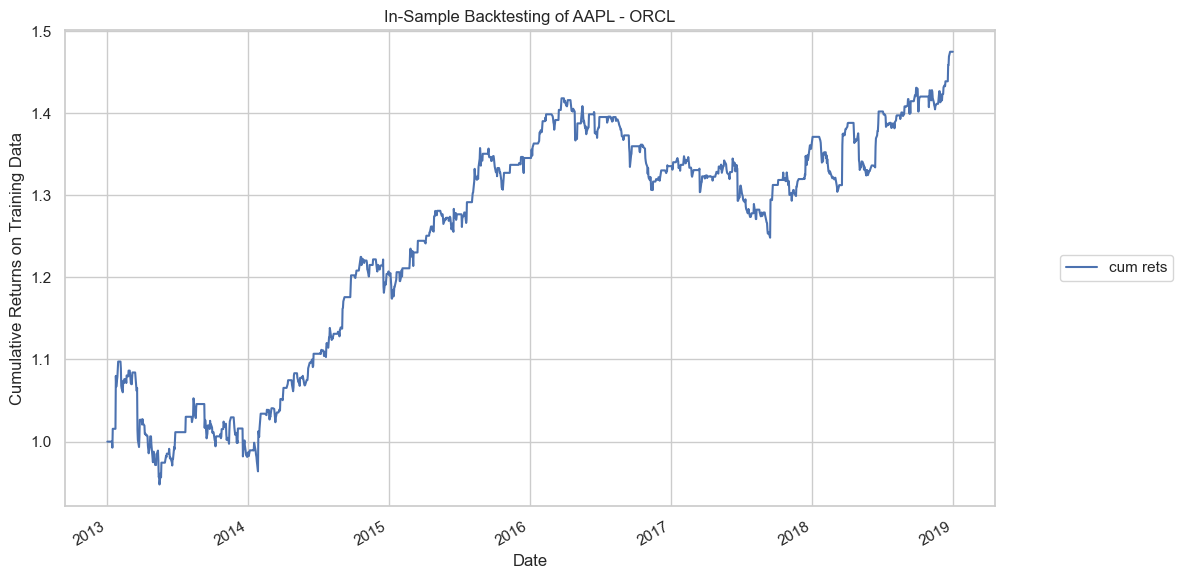

Pair: ('AAPL', 'SPY')
Sharpe Ratio: 0.8971690096637884
Final Cumulative Returns: 1.4075986209943332


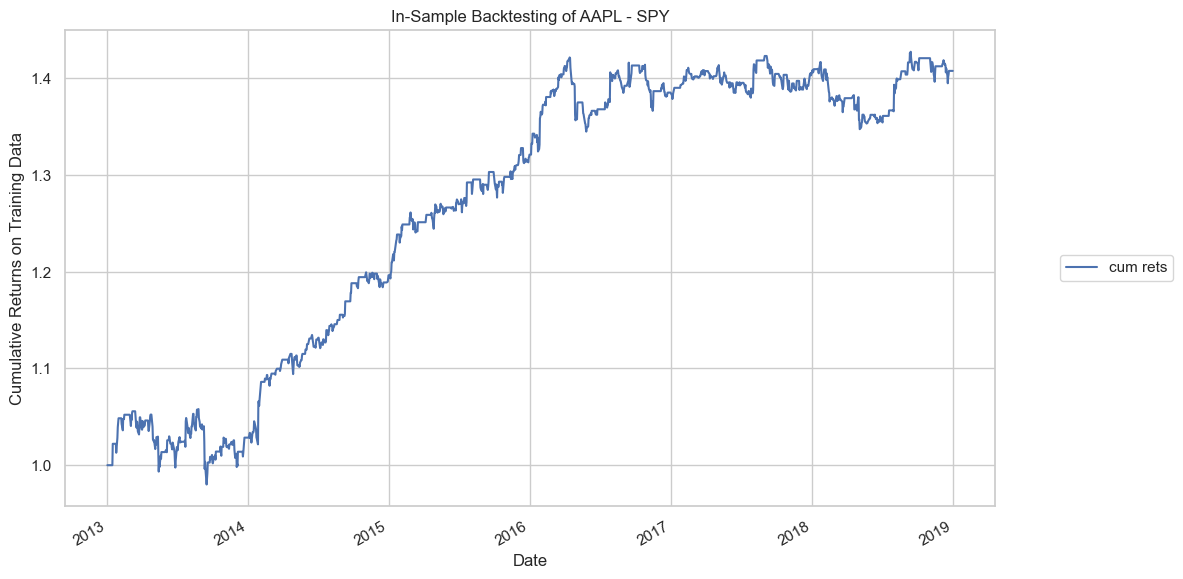

Pair: ('ADBE', 'CSCO')
Sharpe Ratio: 1.37204545225649
Final Cumulative Returns: 1.6826879919963509


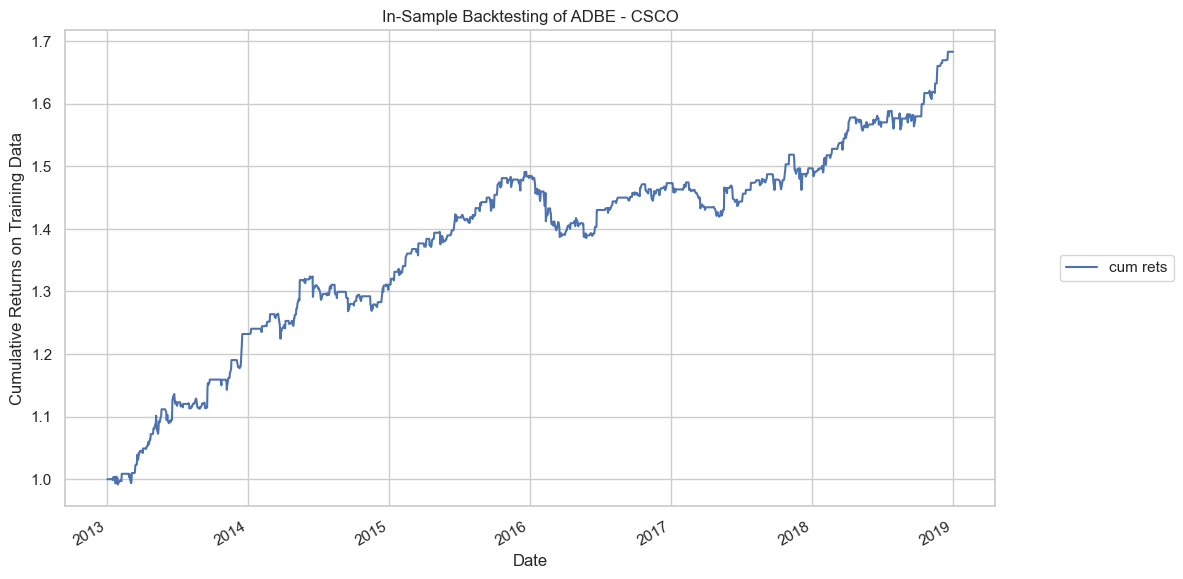

Pair: ('ADBE', 'MSFT')
Sharpe Ratio: 1.2632844785110362
Final Cumulative Returns: 1.5168496430082299


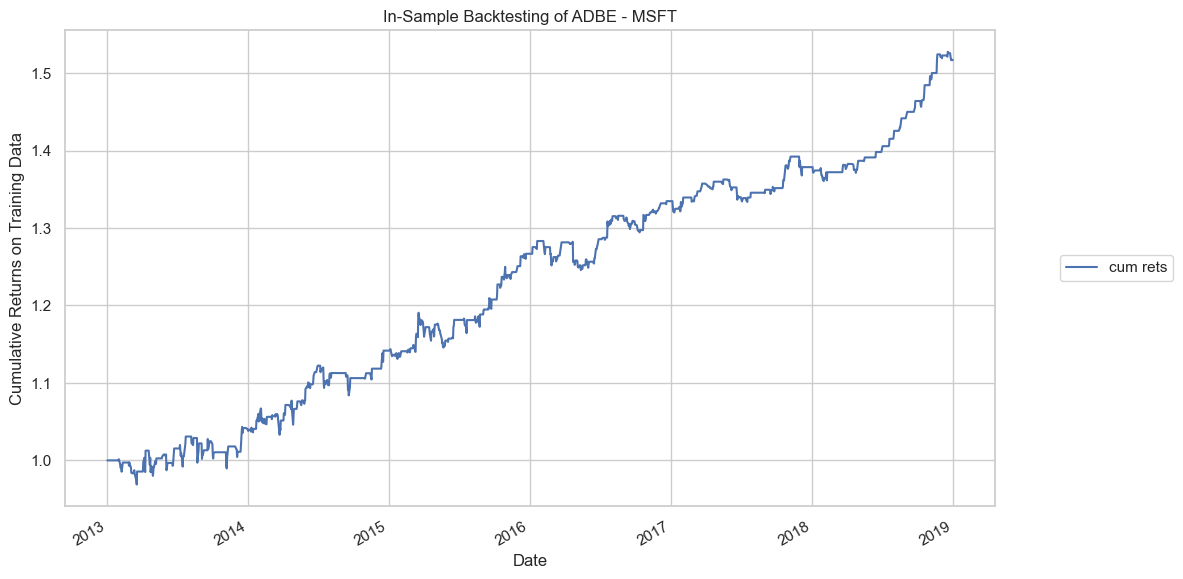

Pair: ('AMD', 'MSFT')
Sharpe Ratio: 1.971050663834341
Final Cumulative Returns: 2.818751974008878


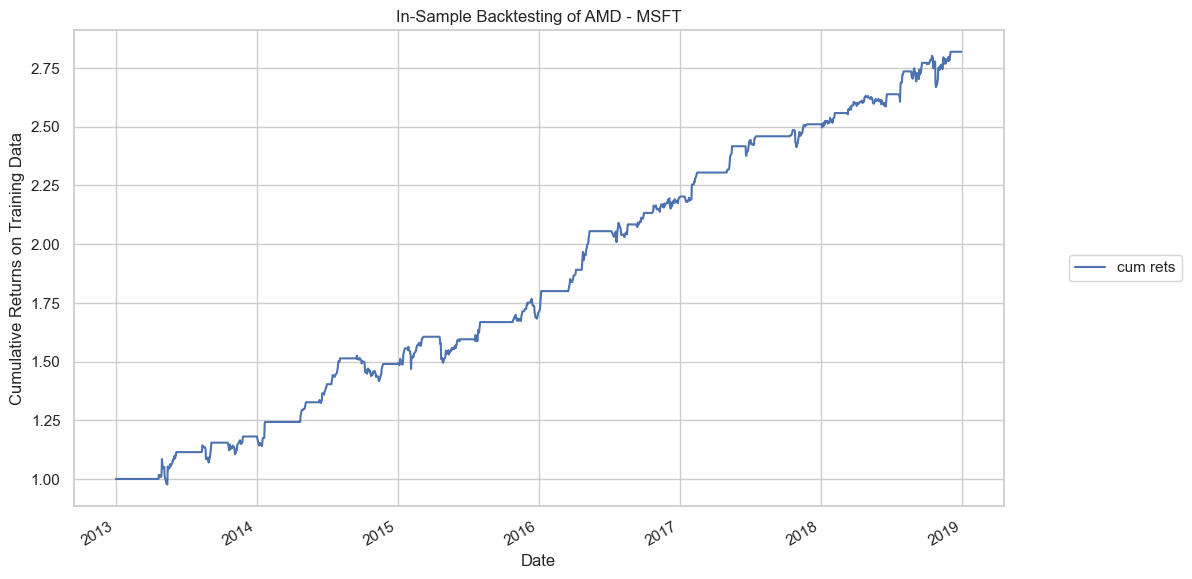

Pair: ('AMZN', 'CSCO')
Sharpe Ratio: 1.3280243200795347
Final Cumulative Returns: 1.8700682889576123


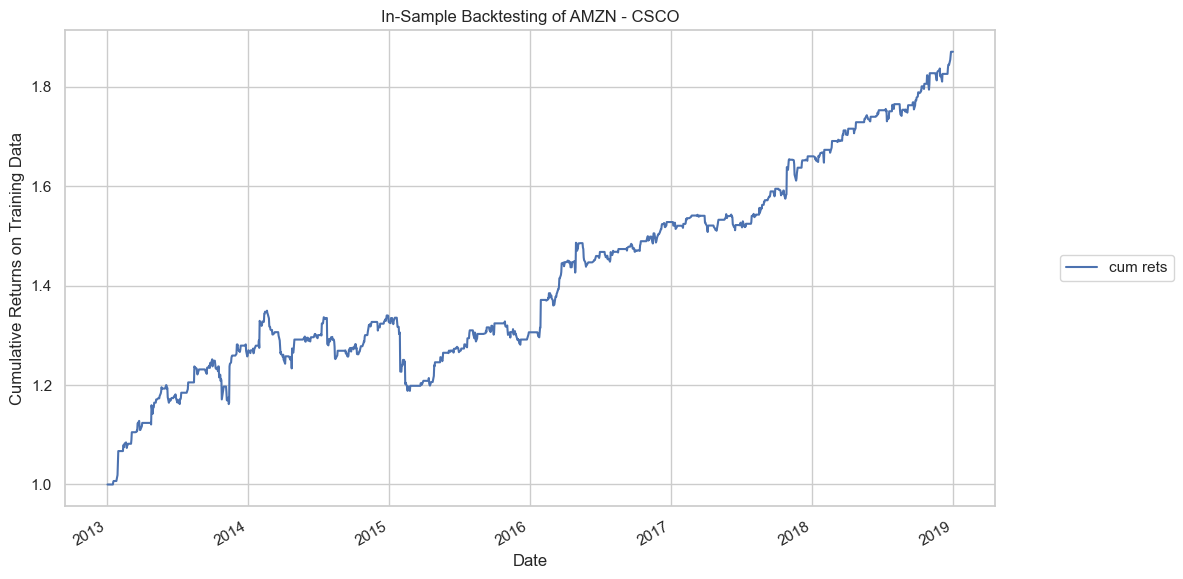

Pair: ('CRM', 'MSFT')
Sharpe Ratio: 1.5104243142520137
Final Cumulative Returns: 1.8967242496792696


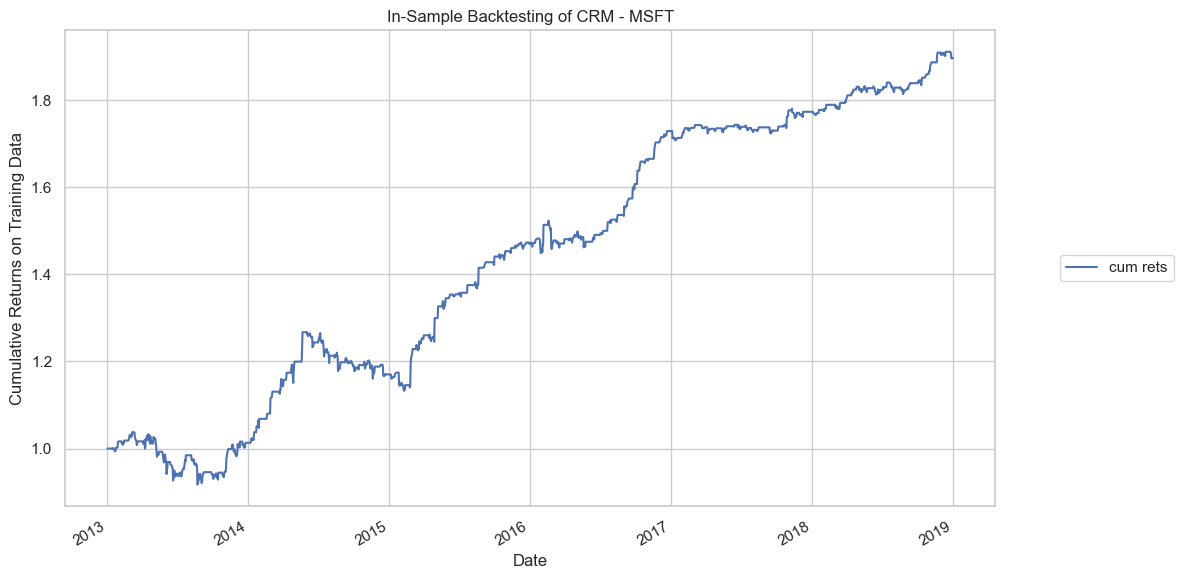

Pair: ('CSCO', 'MSFT')
Sharpe Ratio: 2.1247676755087666
Final Cumulative Returns: 2.048247361152642


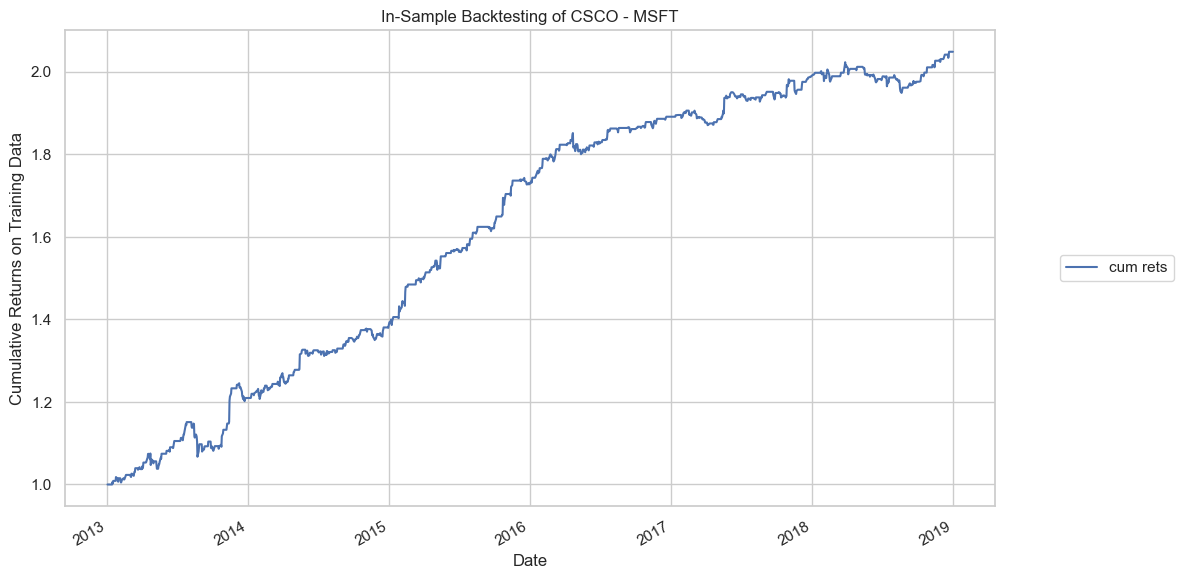

Pair: ('HPQ', 'ORCL')
Sharpe Ratio: 0.5279293711225918
Final Cumulative Returns: 1.3562918361944865


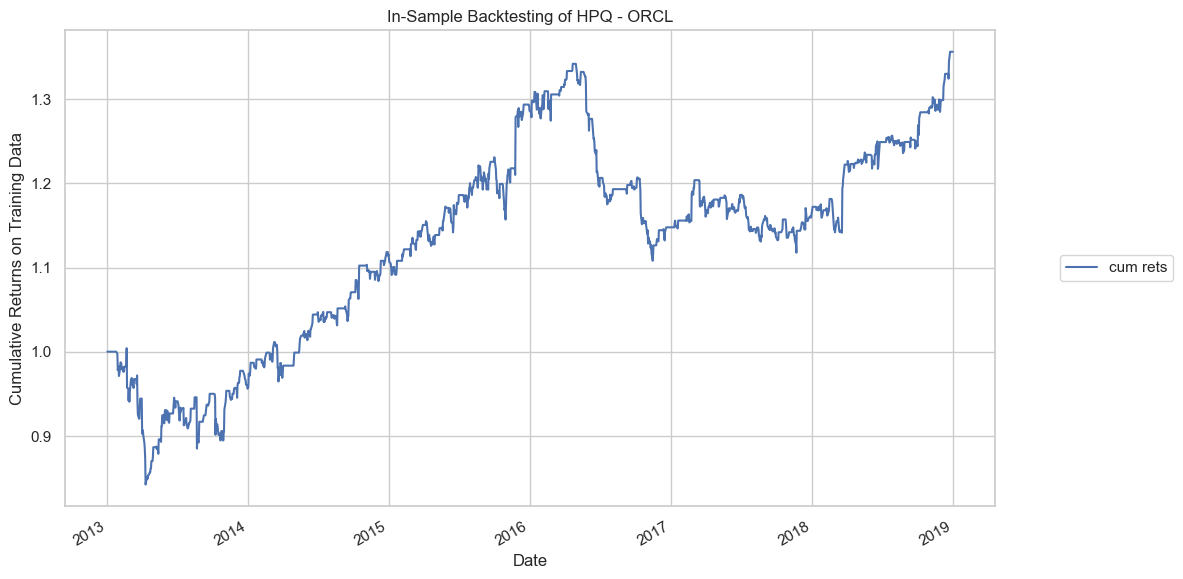

Pair: ('ORCL', 'QQQ')
Sharpe Ratio: 0.919403684749511
Final Cumulative Returns: 1.2908719892000624


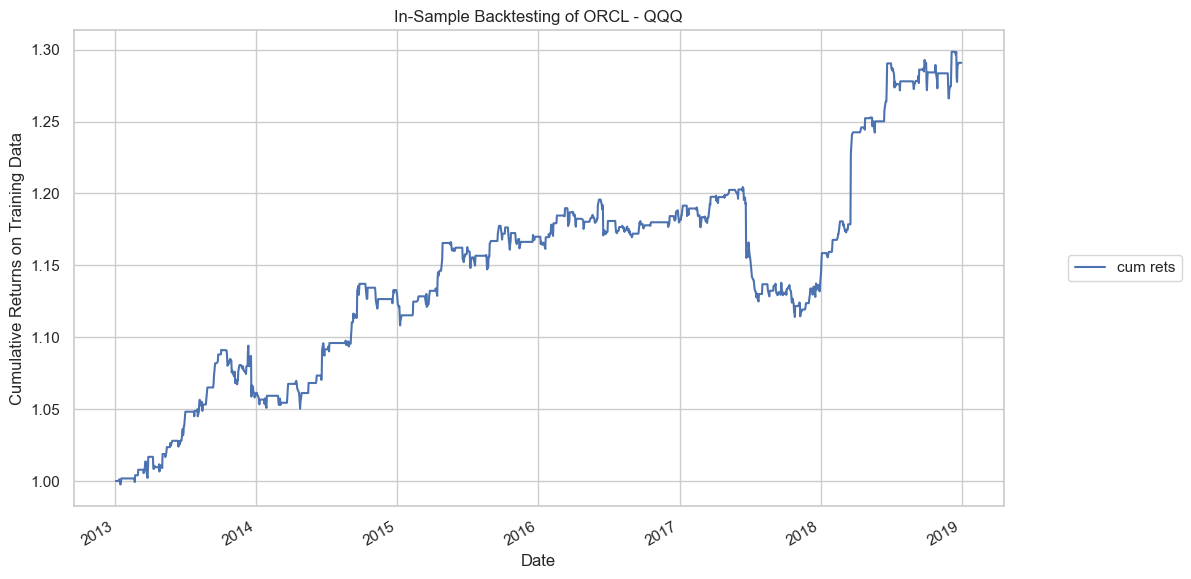

Pair: ('ORCL', 'SPY')
Sharpe Ratio: 0.7704198479317185
Final Cumulative Returns: 1.2402162919319129


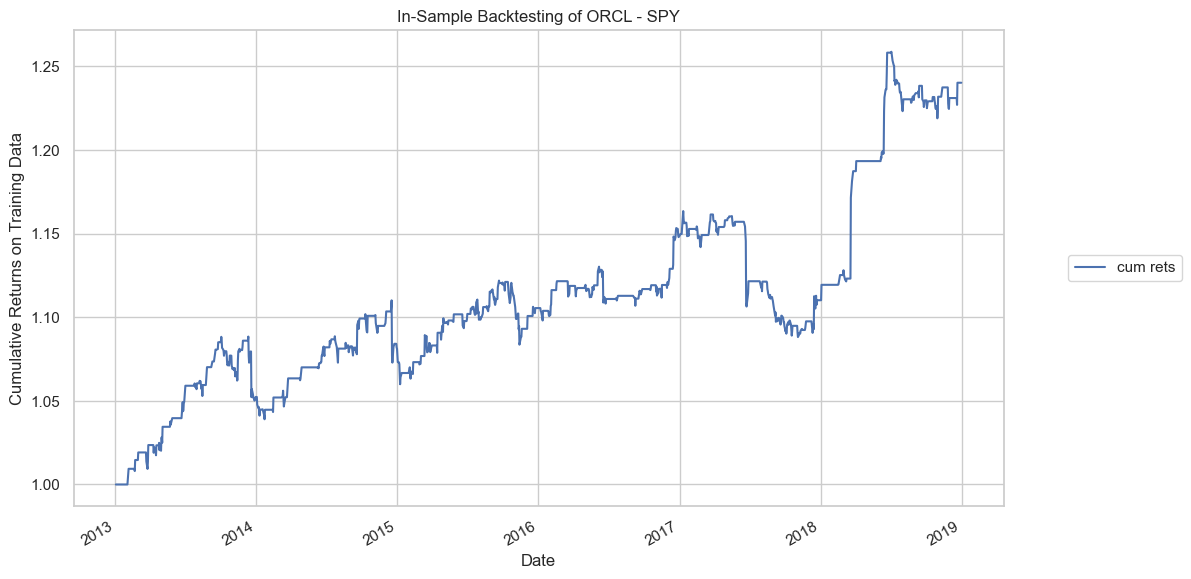

Pair: ('ORCL', 'TXN')
Sharpe Ratio: 1.1028462806405008
Final Cumulative Returns: 1.5170549842025698


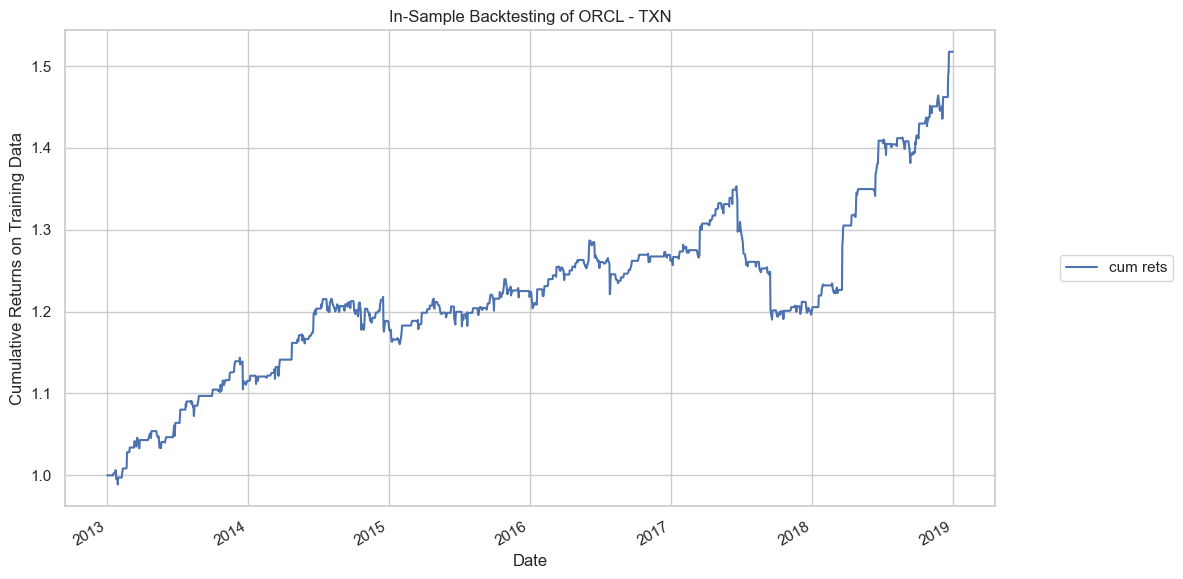

Pair: ('ORCL', 'XLK')
Sharpe Ratio: 1.0907364804500337
Final Cumulative Returns: 1.3463134314101353


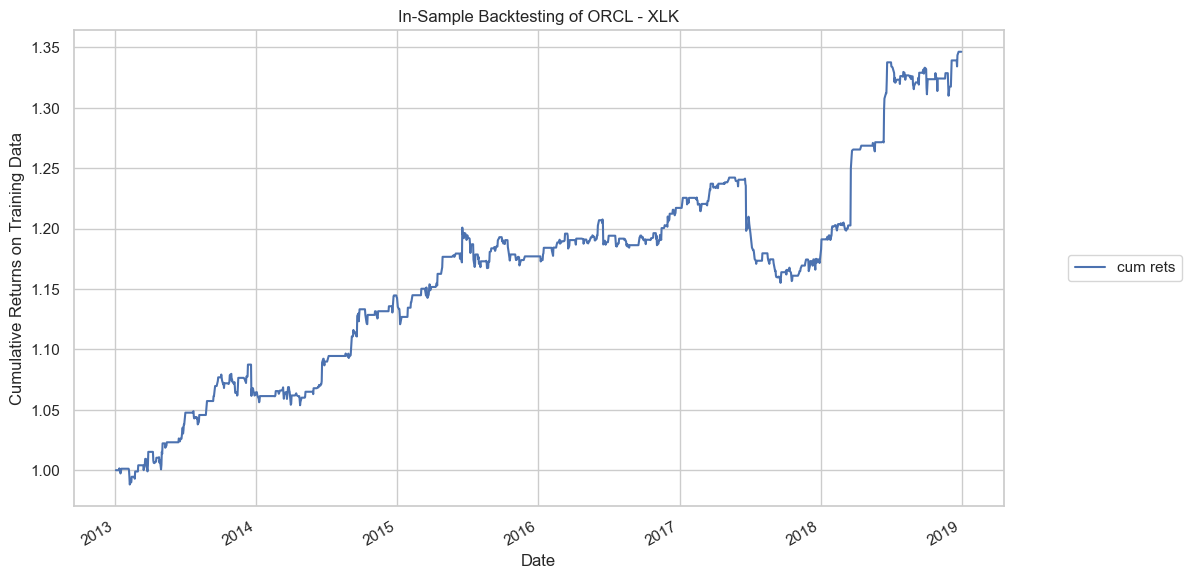

Pair: ('QQQ', 'SPY')
Sharpe Ratio: 1.6397384059234332
Final Cumulative Returns: 1.207146598545284


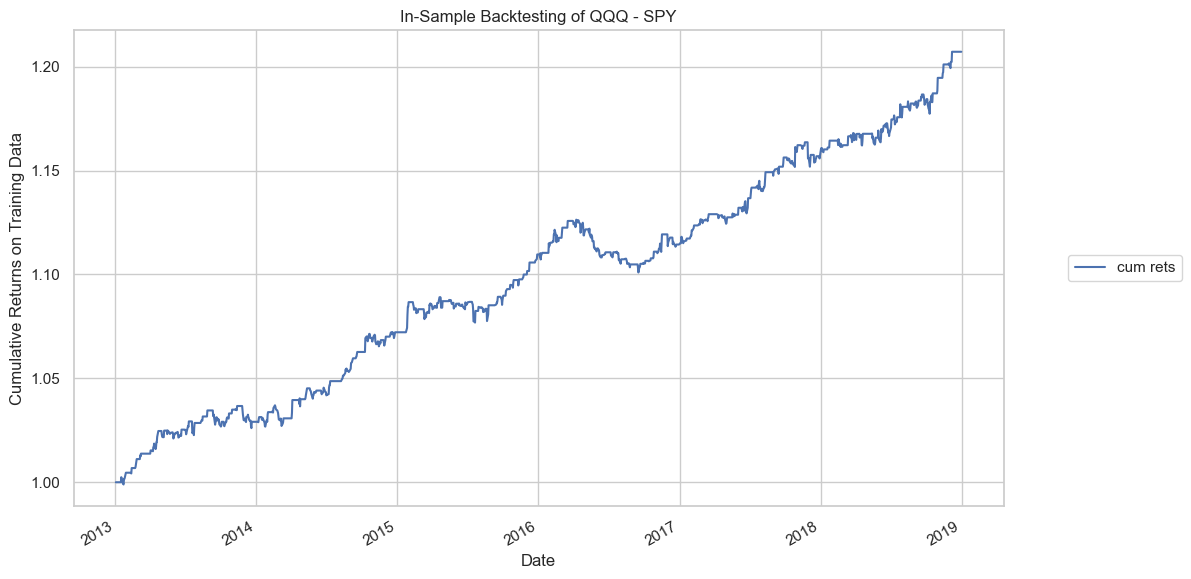

Pair: ('SPY', 'XLK')
Sharpe Ratio: 1.390879744375628
Final Cumulative Returns: 1.1747837907537582


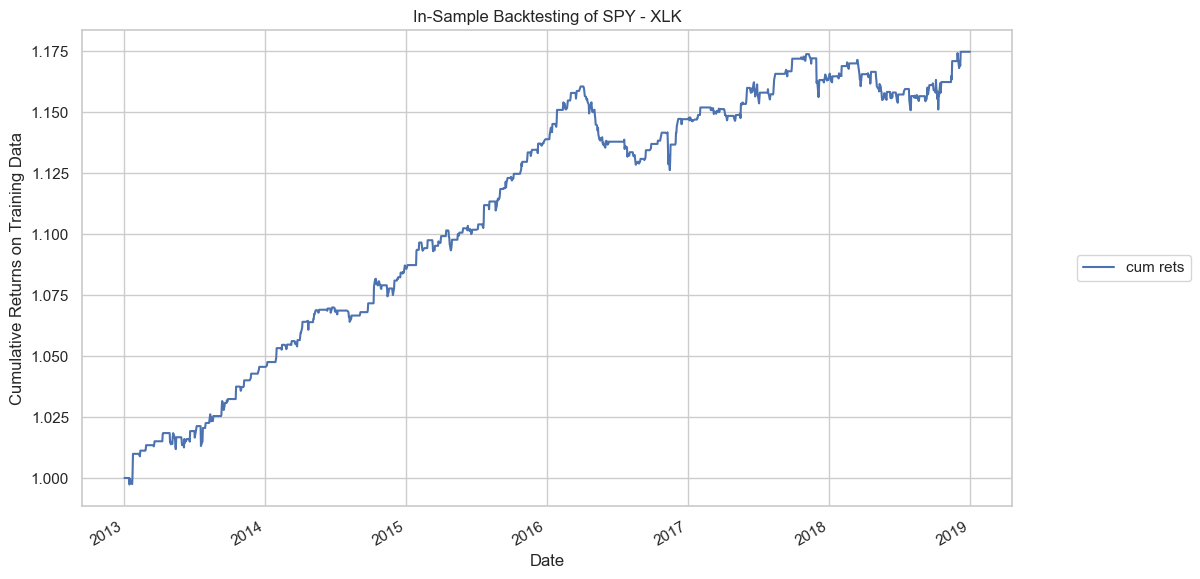

In [49]:
pairs = [
    ('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ADBE', 'CSCO'), ('ADBE', 'MSFT'), ('AMD', 'MSFT'),
    ('AMZN', 'CSCO'), ('CRM', 'MSFT'), ('CSCO', 'MSFT'), ('HPQ', 'ORCL'), ('ORCL', 'QQQ'),
    ('ORCL', 'SPY'), ('ORCL', 'TXN'), ('ORCL', 'XLK'), ('QQQ', 'SPY'), ('SPY', 'XLK')
]

for pair in pairs:
    x_train = df[pair[0]]  # x is the first stock in the pair
    y_train = df[pair[1]]  # y is the second stock in the pair

    # Run the backtest for the current pair
    tmp_train, sharpe_train = backtest(x_train, y_train)

    # Print the Sharpe ratio and final cumulative returns
    print(f"Pair: {pair}")
    print(f"Sharpe Ratio: {sharpe_train}")
    print(f"Final Cumulative Returns: {tmp_train.values[-1]}")

    # Plot the cumulative returns for the training data
    tmp_train.iloc[0] = 1
    tmp_train.index = df.index
    tmp_train.plot(figsize=(12,7), grid=True)
    plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.ylabel('Cumulative Returns on Training Data')
    plt.title(f'In-Sample Backtesting of {pair[0]} - {pair[1]}')
    plt.show()


So I will choose only those pair which have sharpe ratio > 1 and cummulative returns > 50% for my portfolio
1. Pair: ('ADBE', 'CSCO')<br>
Sharpe Ratio: 1.37204545225649<br>
Final Cumulative Returns: 1.6826879919963509<br>

2. Pair: ('AMD', 'MSFT')<br>
Sharpe Ratio: 1.971050663834341<br>
Final Cumulative Returns: 2.818751974008878<br>

3. Pair: ('AMZN', 'CSCO')<br>
Sharpe Ratio: 1.3280243200795347<br>
Final Cumulative Returns: 1.8700682889576123

4. Pair: ('CRM', 'MSFT')<br>
Sharpe Ratio: 1.5104243142520137<br>
Final Cumulative Returns: 1.8967242496792696<br>

5. Pair: ('CSCO', 'MSFT')<br>
Sharpe Ratio: 2.1247676755087666<br>
Final Cumulative Returns: 2.048247361152642<br>



**Sharpe ratio is directly proportional to risk and cumulative returns are directly proportional to profit, I will give equal importance to both factors. To calculate the weight for each pair, I will first normalize both the Sharpe ratios and cumulative returns separately, and then take the average of the normalized values to determine the final weight for each pair.**

In [55]:
pairs2 = [
    ('ADBE', 'CSCO', 1.372, 1.6826879919963509),
    ('AMD', 'MSFT', 1.971, 2.818751974008878),
    ('AMZN', 'CSCO', 1.328, 1.8700682889576123),
    ('CRM', 'MSFT', 1.510, 1.8967242496792696),
    ('CSCO', 'MSFT', 2.124, 2.048247361152642)
]

sharpe_ratios = [pair[2] for pair in pairs2]
cummulative_returns = [pair[3] for pair in pairs2]
sharpe_weight = np.array(sharpe_ratios)/sum(sharpe_ratios)
cummulative_weight = np.array(cummulative_returns)/sum(cummulative_returns)
combined_weight = (sharpe_weight + cummulative_weight) / 2
normalized_weights = combined_weight / sum(combined_weight)
portfolio_df = pd.DataFrame({
    'Pair': [pair[0] + '-' + pair[1] for pair in pairs2],
    'Sharpe Ratio': sharpe_ratios,
    'Cumulative Returns': cummulative_returns,
    'Weight': normalized_weights
})

print(portfolio_df)

        Pair  Sharpe Ratio  Cumulative Returns    Weight
0  ADBE-CSCO         1.372            1.682688  0.164154
1   AMD-MSFT         1.971            2.818752  0.255277
2  AMZN-CSCO         1.328            1.870068  0.170587
3   CRM-MSFT         1.510            1.896724  0.182836
4  CSCO-MSFT         2.124            2.048247  0.227145


In [56]:
0.16415*1.682688 + 0.255277*2.818752 + 0.1705587*1.870068 + 0.182836*1.896724 + 2.04247*0.22714

2.1254482215596